In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import torch
import torch.nn as nn
import scipy
import sklearn
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import requests
from io import StringIO

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob

# get data file names
folder_path = '/content/drive/MyDrive/COVID-Neural-Net/data/'
filenames = glob.glob(folder_path + "/*.csv")
dfs = [pd.read_csv(filename) for filename in filenames]

# concatenate all data into one DataFrame
df = pd.concat(dfs, ignore_index=True)

In [ ]:
# Drop data that appears in less than half of the samples
df = df.drop(labels=['rapid_flu_results', 'rapid_strep_results', 'rr', 'rhonchi', 'wheezes', 'sys', 'dia', 'sats', 'ctab', 'days_since_symptom_onset', 'cough_severity',
                     'sob_severity', 'cxr_findings', 'cxr_impression', 'cxr_label', 'cxr_link', 'er_referral', 'test_name', 'swab_type', 'batch_date'], axis=1)

In [ ]:
columns = ['covid19_test_results', 'age',
       'high_risk_exposure_occupation', 'high_risk_interactions', 'diabetes',
       'chd', 'htn', 'cancer', 'asthma', 'copd', 'autoimmune_dis', 'smoker',
       'temperature', 'pulse', 'labored_respiration', 'cough', 'fever', 'sob',
       'diarrhea', 'fatigue', 'headache', 'loss_of_smell', 'loss_of_taste',
       'runny_nose', 'muscle_sore', 'sore_throat']

# categorical_features = ['test_name', 'swab_type']

continuous_features = ['temperature', 'pulse']

binary_features = ['covid19_test_results', 'diabetes', 'chd', 'htn', 'cancer', 'asthma', 'copd', 'autoimmune_dis', 'high_risk_exposure_occupation', 'high_risk_interactions', 'smoker', 'labored_respiration', 'cough',
                   'fever', 'sob', 'diarrhea', 'fatigue', 'headache', 'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore', 'sore_throat']

# One Hot Encoding
Our categorical data is mostly strings, we need to convert these to numerical types.

 - Binary Data
    - We want these to be labelled as 0s and 1s
 - Multi-categorical
    - We'll label these in increments, ie 0, 1, 2, ..

In [ ]:
df.head()

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,labored_respiration,cough,fever,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,31,False,NaN,False,False,False,False,False,False,False,False,37.10,63.0,False,False,NaN,False,False,False,False,False,False,False,False,False
1,Negative,54,False,True,False,False,True,False,False,False,False,False,36.75,71.0,False,False,False,False,False,False,False,False,False,False,False,False
2,Negative,32,False,False,False,False,False,False,False,False,False,False,36.45,62.0,False,False,False,False,False,False,False,False,False,False,False,False
3,Negative,25,False,False,False,False,False,False,False,False,False,False,36.85,95.0,NaN,True,True,True,False,False,True,False,False,False,False,False
4,Negative,33,False,False,False,False,False,False,False,False,False,False,36.75,70.0,False,False,NaN,False,False,False,False,False,False,False,False,False


In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder

# integer encode
label_encoder = LabelEncoder()

for col in binary_features:
    df[col] = df[col] * 1
    # if df[col].dtype != np.number:
    #     df[col] = label_encoder.fit_transform(df[col])
    # df[col] = pd.get_dummies(col, prefix=col)
    
# for col in binary_features:
#     if len(df[col].unique().tolist()) > 2:
#         df[col] = df[col] - 1

df.head()

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,labored_respiration,cough,fever,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,31,0,NaN,0,0,0,0,0,0,0,0,37.10,63.0,0,0,NaN,0,0,0,0,0,0,0,0,0
1,Negative,54,0,1,0,0,1,0,0,0,0,0,36.75,71.0,0,0,0,0,0,0,0,0,0,0,0,0
2,Negative,32,0,0,0,0,0,0,0,0,0,0,36.45,62.0,0,0,0,0,0,0,0,0,0,0,0,0
3,Negative,25,0,0,0,0,0,0,0,0,0,0,36.85,95.0,NaN,1,1,1,0,0,1,0,0,0,0,0
4,Negative,33,0,0,0,0,0,0,0,0,0,0,36.75,70.0,0,0,NaN,0,0,0,0,0,0,0,0,0


In [ ]:
def one_hot(X):
    # dummy_cols = list(set(X[categorical_features + binary_features]))
    dummy_cols = list(set(X[binary_features]))
    X = pd.get_dummies(X, columns=dummy_cols)
    print(X.shape)
    return X

df = one_hot(df)

(93995, 49)


In [ ]:
df = df.drop('covid19_test_results_Negative', axis=1)
df.head()

,age,temperature,pulse,diabetes_0,diabetes_1,loss_of_smell_0,loss_of_smell_1,cancer_0,cancer_1,high_risk_exposure_occupation_0,high_risk_exposure_occupation_1,muscle_sore_0,muscle_sore_1,diarrhea_0,diarrhea_1,cough_0,cough_1,smoker_0,smoker_1,headache_0,headache_1,fever_0,fever_1,fatigue_0,fatigue_1,sob_0,sob_1,sore_throat_0,sore_throat_1,loss_of_taste_0,loss_of_taste_1,autoimmune_dis_0,autoimmune_dis_1,high_risk_interactions_0,high_risk_interactions_1,chd_0,chd_1,runny_nose_0,runny_nose_1,htn_0,htn_1,copd_0,copd_1,labored_respiration_0,labored_respiration_1,covid19_test_results_Positive,asthma_0,asthma_1
0,31,37.10,63.0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0
1,54,36.75,71.0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0
2,32,36.45,62.0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0
3,25,36.85,95.0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0
4,33,36.75,70.0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0


# Normalize Continuous Features

In [ ]:
from sklearn import preprocessing

x = df[continuous_features].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df[continuous_features] = pd.DataFrame(x_scaled)
df['age'] = df['age']/100

In [ ]:
df.head()

,age,temperature,pulse,diabetes_0,diabetes_1,loss_of_smell_0,loss_of_smell_1,cancer_0,cancer_1,high_risk_exposure_occupation_0,high_risk_exposure_occupation_1,muscle_sore_0,muscle_sore_1,diarrhea_0,diarrhea_1,cough_0,cough_1,smoker_0,smoker_1,headache_0,headache_1,fever_0,fever_1,fatigue_0,fatigue_1,sob_0,sob_1,sore_throat_0,sore_throat_1,loss_of_taste_0,loss_of_taste_1,autoimmune_dis_0,autoimmune_dis_1,high_risk_interactions_0,high_risk_interactions_1,chd_0,chd_1,runny_nose_0,runny_nose_1,htn_0,htn_1,copd_0,copd_1,labored_respiration_0,labored_respiration_1,covid19_test_results_Positive,asthma_0,asthma_1
0,0.31,0.590164,0.224,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0
1,0.54,0.532787,0.288,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0
2,0.32,0.483607,0.216,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0
3,0.25,0.549180,0.480,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0
4,0.33,0.532787,0.280,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0


# Missing Data
Check for missing data

In [ ]:
df.isna().sum()

age                                    0
temperature                        46453
pulse                              45716
diabetes_0                             0
diabetes_1                             0
loss_of_smell_0                        0
loss_of_smell_1                        0
cancer_0                               0
cancer_1                               0
high_risk_exposure_occupation_0        0
high_risk_exposure_occupation_1        0
muscle_sore_0                          0
muscle_sore_1                          0
diarrhea_0                             0
diarrhea_1                             0
cough_0                                0
cough_1                                0
smoker_0                               0
smoker_1                               0
headache_0                             0
headache_1                             0
fever_0                                0
fever_1                                0
fatigue_0                              0
fatigue_1       

# Impute Missing Values

In [ ]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        for col in X.columns:
            self.fill = pd.Series([X[c].median()
                if (col in binary_features) else X[c].mean() for c in X],
                index=X.columns)

        #self.fill = pd.Series([X[c].median()
            #if X[c].dtype == np.dtype('float64') else X[c].mean() for c in X],
            #index=X.columns)

        #self.fill = pd.Series([X[c].mean() for c in X 
                               #if X[c].dtype == np.dtype('float64') 
                               #X[c].median() for c in X]
                              #,index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

results = df['covid19_test_results_Positive']
X = df.drop('covid19_test_results_Positive', axis=1)
df = DataFrameImputer().fit_transform(X)
df = df.join(results)
print(df.isnull().values.any())

False


In [ ]:
df = df.dropna()
df.shape

(93995, 48)

In [ ]:
df.head()

,age,temperature,pulse,diabetes_0,diabetes_1,loss_of_smell_0,loss_of_smell_1,cancer_0,cancer_1,high_risk_exposure_occupation_0,high_risk_exposure_occupation_1,muscle_sore_0,muscle_sore_1,diarrhea_0,diarrhea_1,cough_0,cough_1,smoker_0,smoker_1,headache_0,headache_1,fever_0,fever_1,fatigue_0,fatigue_1,sob_0,sob_1,sore_throat_0,sore_throat_1,loss_of_taste_0,loss_of_taste_1,autoimmune_dis_0,autoimmune_dis_1,high_risk_interactions_0,high_risk_interactions_1,chd_0,chd_1,runny_nose_0,runny_nose_1,htn_0,htn_1,copd_0,copd_1,labored_respiration_0,labored_respiration_1,asthma_0,asthma_1,covid19_test_results_Positive
0,0.31,0.590164,0.224,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0
1,0.54,0.532787,0.288,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0
2,0.32,0.483607,0.216,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
3,0.25,0.549180,0.480,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0
4,0.33,0.532787,0.280,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0


# SMOTE #
Also known as Informed Over Sampling: Synthetic Minority Over-sampling Technique for imbalanced data

This method is used to avoid overfitting from having exact replicas of the minority samples. We will take a subset of data from the minority class and create new synthetic similar samples in the dataset. Then train the models off the new dataset.

Pros:
- No loss of information
- Mitigates the issue of overfitting

Cons:
- May result in increase in overlapping of classes, and may introduce noise
- Not effective on high dimmensional data (Not an issue here)

In [ ]:
########## Split Features and Target Varible ############
X = df.drop(columns=['covid19_test_results_Positive'])
y = df['covid19_test_results_Positive']

This pipeline runs our data through a 0.5 SMOTE, followed by undersampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

########## Define undersample strategy ##########
undersample = RandomUnderSampler(sampling_strategy='majority')

########## Define SMOTE strategy ##########
SMOTE_over = SMOTE(sampling_strategy=0.5)

steps = [
    ('SMOTE', SMOTE_over),
    ('under', undersample)
]
pipeline = Pipeline(steps=steps)

In [ ]:
X_smoteunder, y_smoteunder = pipeline.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y_smoteunder)
print(counter)
pd.DataFrame(X_smoteunder).head()

resampled = pd.DataFrame(X_smoteunder, columns=df.drop('covid19_test_results_Positive', axis=1).columns)
resampled['covid19_test_results_Positive'] = y_smoteunder


Counter({0: 46341, 1: 46341})


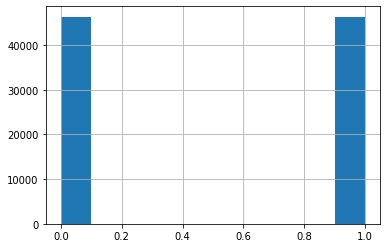

In [ ]:
resampled['covid19_test_results_Positive'].hist()

Dropping missing variables yields a dataset with zero positive covid19 test results.

In [ ]:
print(df['covid19_test_results_Positive'].apply(lambda x: x == 1).sum())

1313


In [ ]:
resampled.head()

,age,temperature,pulse,diabetes_0,diabetes_1,loss_of_smell_0,loss_of_smell_1,cancer_0,cancer_1,high_risk_exposure_occupation_0,high_risk_exposure_occupation_1,muscle_sore_0,muscle_sore_1,diarrhea_0,diarrhea_1,cough_0,cough_1,smoker_0,smoker_1,headache_0,headache_1,fever_0,fever_1,fatigue_0,fatigue_1,sob_0,sob_1,sore_throat_0,sore_throat_1,loss_of_taste_0,loss_of_taste_1,autoimmune_dis_0,autoimmune_dis_1,high_risk_interactions_0,high_risk_interactions_1,chd_0,chd_1,runny_nose_0,runny_nose_1,htn_0,htn_1,copd_0,copd_1,labored_respiration_0,labored_respiration_1,asthma_0,asthma_1,covid19_test_results_Positive
0,0.26,0.516393,0.328000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
1,0.52,0.540125,0.335469,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,0.36,0.557377,0.448000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
3,0.33,0.483607,0.344000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
4,0.33,0.532787,0.184000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0


In [ ]:
df.to_csv('/content/drive/MyDrive/COVID-Neural-Net/datasets/input/inputdataset.csv', index=False)
resampled.to_csv('/content/drive/MyDrive/COVID-Neural-Net/datasets/input/resampledinput.csv', index=False)